# Load data:

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load dữ liệu
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Data Description:

In [66]:
print(f"Number of rows in sales: {sales.shape[0]}")
print(f"Number of columns in sales: {sales.shape[1]}")
print("Dataset info:")
print(sales.info())

print("Output variable statistics (item_cnt_day):")
print(sales['item_cnt_day'].describe())
print(f"There are {(sales['item_cnt_day']==0).sum()} training items with zero sales")

Number of rows in sales: 2935849
Number of columns in sales: 6
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
Output variable statistics (item_cnt_day):
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64
There are 0 training items with zero sales


In [67]:
# Check for suspicious output values
# < 0 la do tra lai do chu khong phai la du lieu loi
print("Number of item_cnt_day < 0:", (sales['item_cnt_day'] < 0).sum())
print("Number of item_cnt_day > 1000:", (sales['item_cnt_day'] > 1000).sum())

Number of item_cnt_day < 0: 7356
Number of item_cnt_day > 1000: 1


# Univariate EDA:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Total Items Sold')

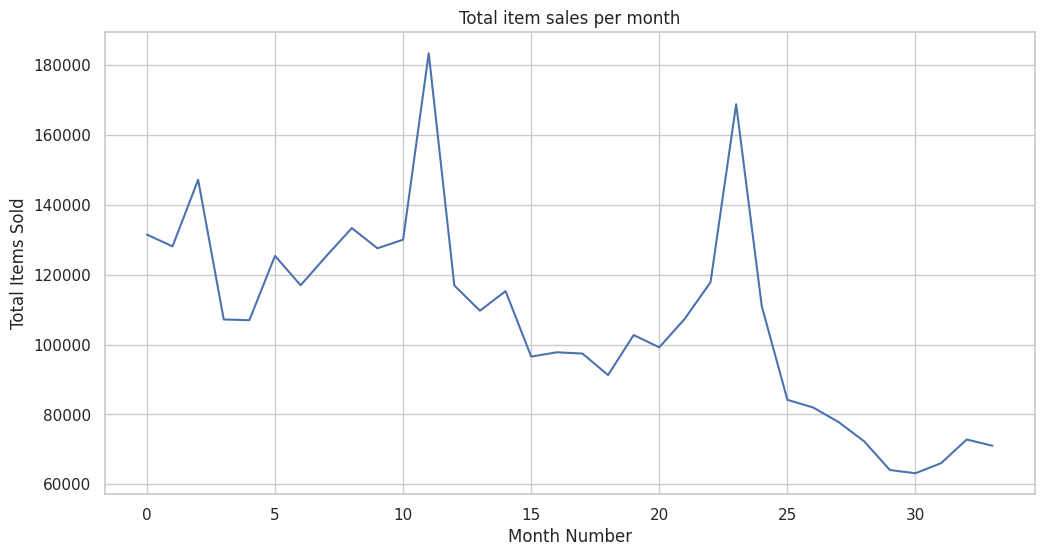

In [68]:
# Convert to datetime
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

# Monthly total item sales
monthly_sales = sales.groupby('date_block_num')['item_cnt_day'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title("Total item sales per month")
plt.xlabel("Month Number")
plt.ylabel("Total Items Sold")

# Null values & Outliers:

Check for NULL values:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
Outliers (below 1%): < 1.0
Outliers (above 99%): > 5.0
Mean and 99.9th quantile of "item_cnt_day" are 1.24 and 22.00
Mean and 99.9th quantile of "item_price" are 890.85 and 23990.00


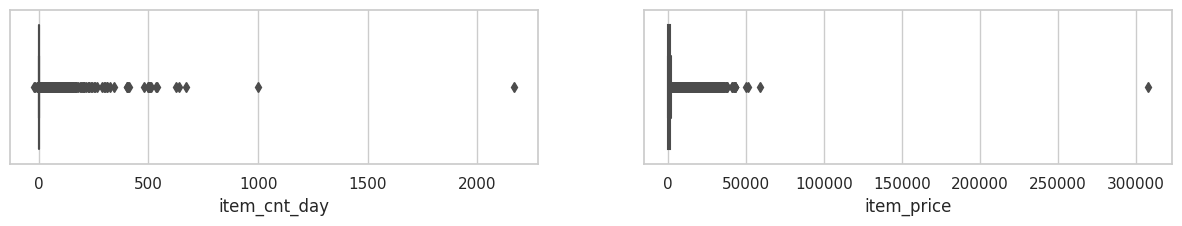

In [69]:
print("Check for NULL values:")
print(sales.isnull().sum())

# Outlier detection
q_low = sales['item_cnt_day'].quantile(0.01)
q_hi = sales['item_cnt_day'].quantile(0.99)

print(f"Outliers (below 1%): < {q_low}")
print(f"Outliers (above 99%): > {q_hi}")


print(f'Mean and 99.9th quantile of "item_cnt_day" are {sales.item_cnt_day.mean():.2f} and {sales.item_cnt_day.quantile(0.999):.2f}')
print(f'Mean and 99.9th quantile of "item_price" are {sales.item_price.mean():.2f} and {sales.item_price.quantile(0.999):.2f}')
fig, axes = plt.subplots(1,2, figsize = (15,2))
_ = sns.boxplot(x=sales.item_cnt_day, ax=axes[0])
_ = sns.boxplot(x=sales.item_price, ax=axes[1])


# Multivariate EDA:

In [70]:
# Prepare monthly aggregated data
train_monthly = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum'
}).reset_index().rename(columns={'item_cnt_day': 'item_cnt'})

train_monthly = train_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

# Add month feature (0 to 11)
train_monthly['month'] = train_monthly['date_block_num'] % 12

# Monthly mean and sum of item sales
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()

# Per-category analysis
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()

# Per-shop analysis
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

## Monthly Seasonality:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


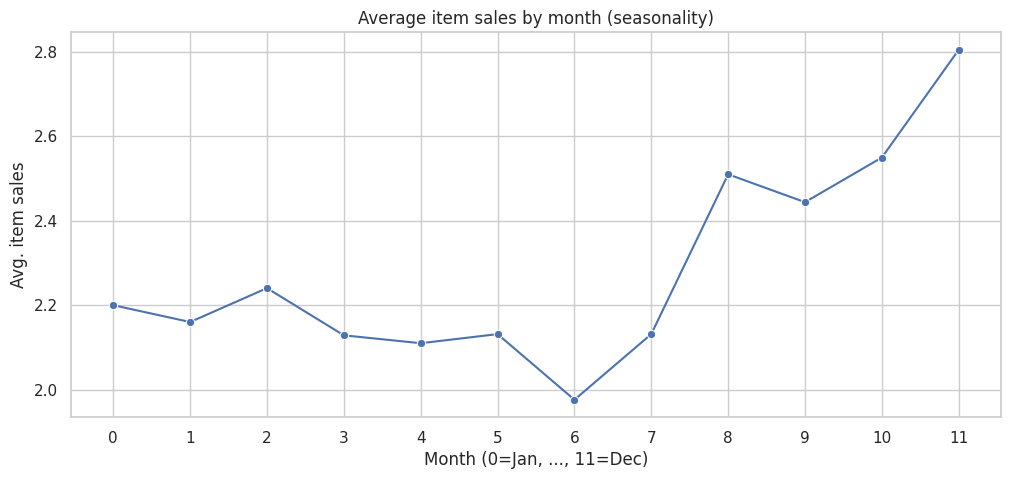

In [71]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='month', y='item_cnt', data=gp_month_mean, marker='o')
plt.title("Average item sales by month (seasonality)")
plt.xlabel("Month (0=Jan, ..., 11=Dec)")
plt.ylabel("Avg. item sales")
plt.xticks(gp_month_mean['month'])
plt.grid(True)
plt.show()

## Category-level Sales:

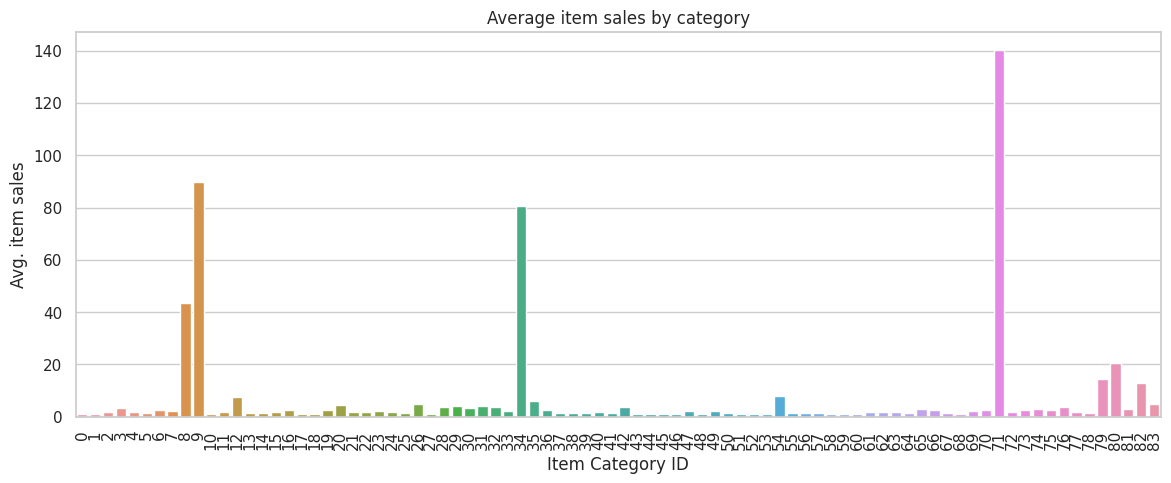

In [72]:
plt.figure(figsize=(14,5))
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_mean)
plt.title("Average item sales by category")
plt.xlabel("Item Category ID")
plt.ylabel("Avg. item sales")
plt.xticks(rotation=90);

## Shop-level Sales:

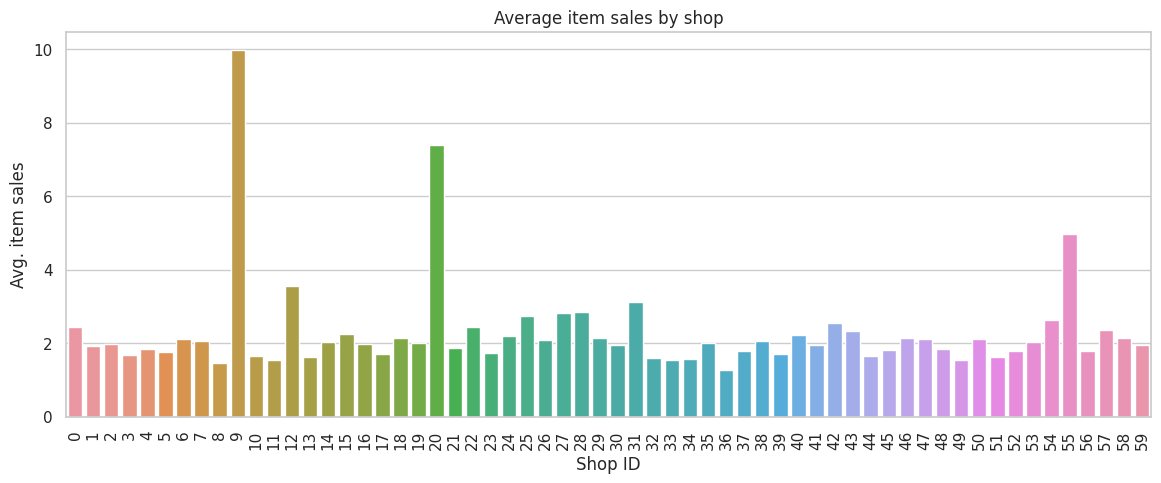

In [73]:
plt.figure(figsize=(14,5))
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_mean)
plt.title("Average item sales by shop")
plt.xlabel("Shop ID")
plt.ylabel("Avg. item sales")
plt.xticks(rotation=90);

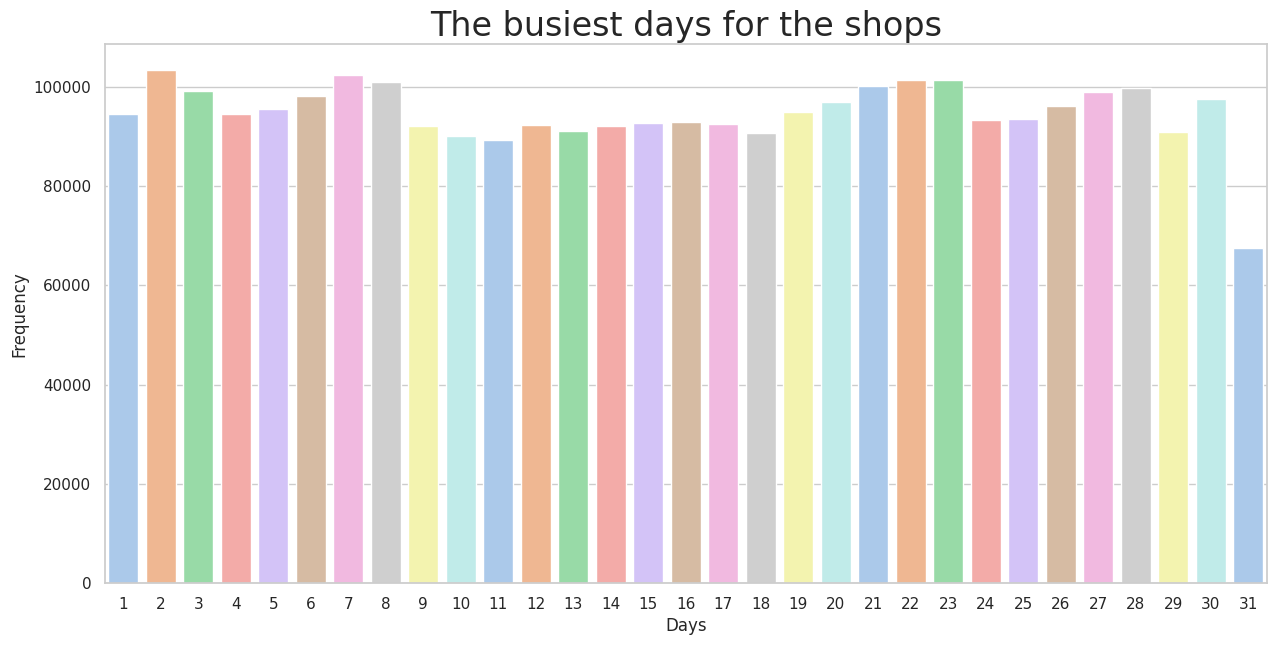

In [74]:
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
valid_dates = sales['date'].dropna()

# Extract day, month, year using pandas datetime accessors
days = valid_dates.dt.day
months = valid_dates.dt.month
years = valid_dates.dt.year

# Plot the frequency of each day of the month
plt.figure(figsize=(15, 7))
sns.countplot(x=days, palette='pastel')
plt.title('The busiest days for the shops', fontsize=24)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


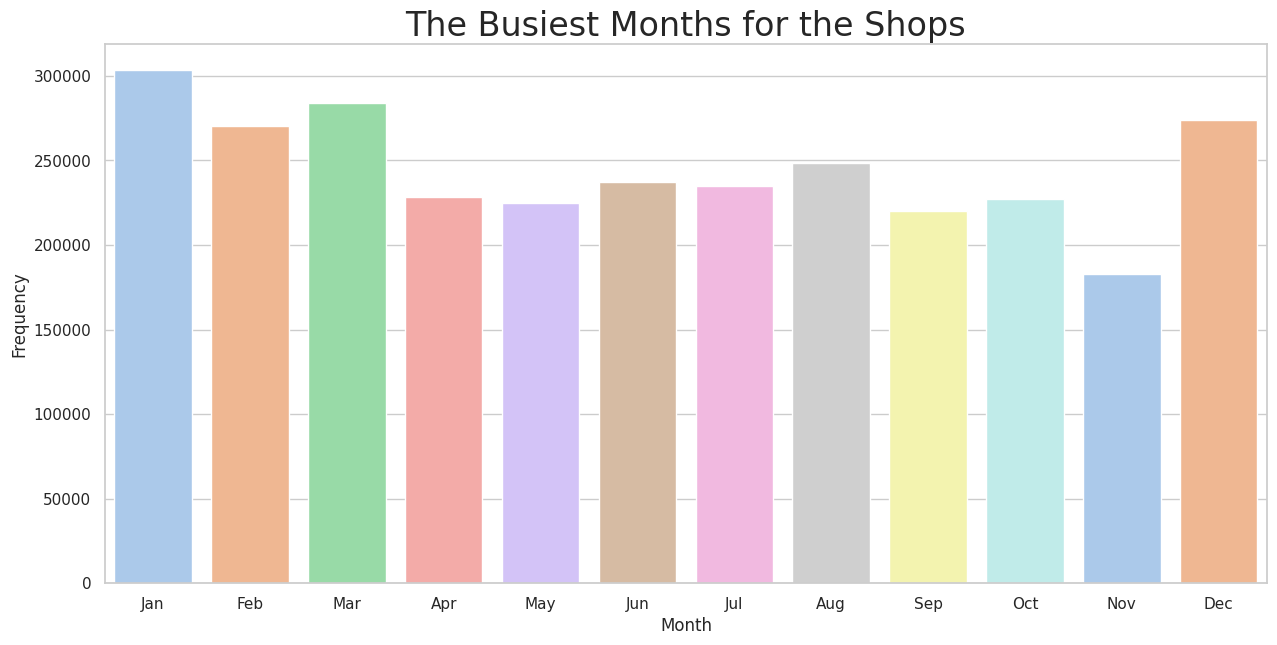

In [75]:
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
valid_dates = sales['date'].dropna()

# Extract months from valid dates
months = valid_dates.dt.month

# Plot the frequency of each month
plt.figure(figsize=(15, 7))
sns.countplot(x=months, palette='pastel')

# Add titles and labels
plt.title('The Busiest Months for the Shops', fontsize=24)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Optional: format x-axis with month names
plt.xticks(
    ticks=range(12),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.show()


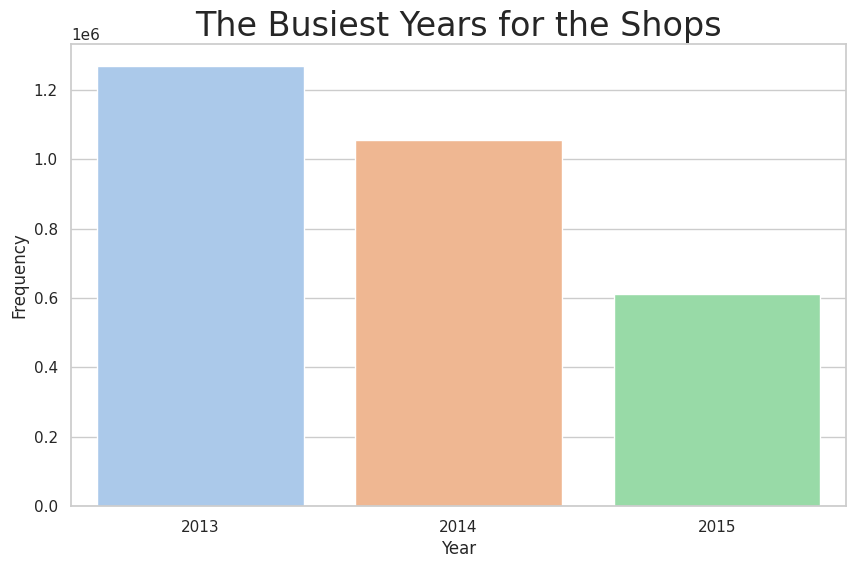

In [76]:
# Ensure 'date' is datetime and drop invalid entries
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
valid_dates = sales['date'].dropna()

# Extract year from valid dates
years = valid_dates.dt.year

# Plot the frequency of each year
plt.figure(figsize=(10, 6))
sns.countplot(x=years, palette='pastel')

# Add titles and labels
plt.title('The Busiest Years for the Shops', fontsize=24)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


## Relationship between item_price and item_cnt_day:

Text(0.5, 1.0, 'item_price vs item_cnt_day')

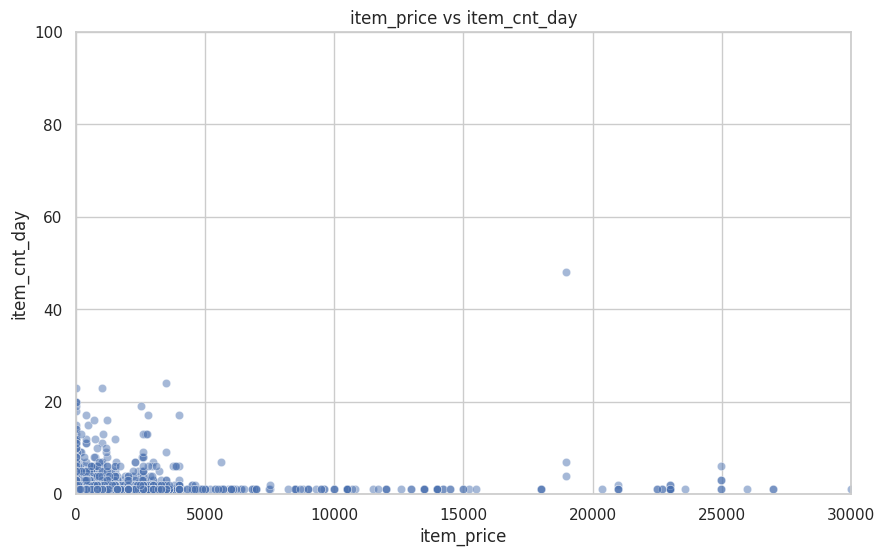

In [77]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=sales.sample(10000), x='item_price', y='item_cnt_day', alpha=0.5)
plt.xlim([0, 30000])
plt.ylim([0, 100])
plt.title("item_price vs item_cnt_day")

## Correlation matrix of numeric features:

Text(0.5, 1.0, 'Correlation matrix of numeric features')

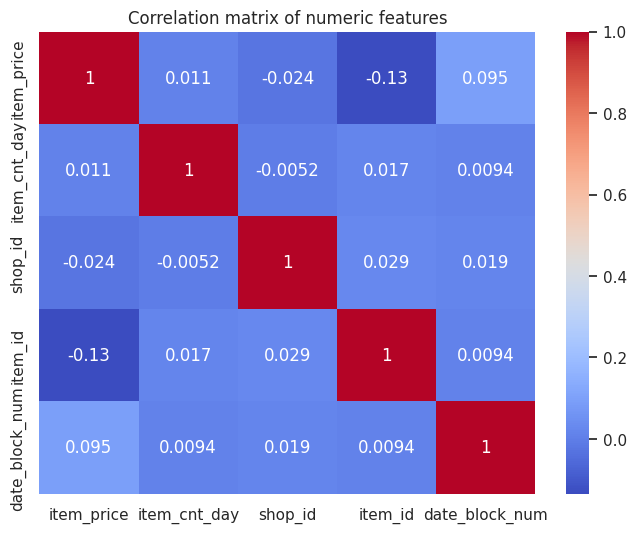

In [78]:
corr_data = sales[['item_price', 'item_cnt_day', 'shop_id', 'item_id', 'date_block_num']]
corr = corr_data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation matrix of numeric features")